# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Predict" data-toc-modified-id="Predict-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict</a></div>

- **Neural Causal Reasoning Model**

# Load Data

In [1]:
import h5py

In [7]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:] 

with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/data.h5', 'r') as fh:
    xc = fh['xc'][:] 
    xe = fh['xe'][:]
    s = fh['s'][:]
    xcTrain = fh['xcTrain'][:]
    xcVal = fh['xcVal'][:]
    xeTrain = fh['xeTrain'][:]
    xeVal = fh['xeVal'][:]
    yTrain = fh['yTrain'][:]
    yVal = fh['yVal'][:]

# Import Libraries

In [11]:
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, dot
from keras.layers.noise import AlphaDropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Build Graph

In [19]:
def ncrm(num_layer=2, hidden_size=300, hidden_activation='relu', dropout_rate=0.2, seed=42, output_activation='sigmoid', loss='mse', optimizer='adam'):
    """
    Hyperparameters
    ----------
    :param num_layer: number of hidden layer
    :param hidden_size: sizes of hidden layer
    :param dropout_rate: dropout layer rate
    :param hidden_activation: activation function of hidden layer
    :param seed: random seed
    :param output_activation: activation function of output layer
    :param loss: loss function
    :param optimizer: optimize method
    
    Returns
    ----------
    Neural Causal Reasoning Model.
    """
    cw = Input(shape=(1,), name='CAUSE')
    cw_emb = Embedding(embedding.shape[0],
                       embedding.shape[-1],
                       weights=[embedding],
                       mask_zero=False,
                       input_length=1,
                       trainable=False,
                       name='CW_EMBEDDING')(cw)
    dense = Flatten(name='CW_FLATTEN')(cw_emb)
    for l in range(num_layer):
        dense = Dense(hidden_size, activation=hidden_activation, name='HIDDEN_%d' % (l+1))(dense)
        if hidden_activation == 'selu':
            dense = AlphaDropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
        else:
            dense = Dropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
    ew = Input(shape=(1,), name='EFFECT')
    ew_emb = Embedding(embedding.shape[0],
                       embedding.shape[-1],
                       weights=[embedding],
                       mask_zero=False,
                       input_length=1,
                       trainable=False,
                       name='EW_EMBEDDING')(ew)
    ew_emb = Flatten(name='EW_FLATTEN')(ew_emb)
    output = dot([dense, ew_emb], axes=-1, normalize=False, name='REASONING')
    output = Dense(1, activation=output_activation, name='OUTPUT')(output)
    model = Model(inputs=[cw, ew], outputs=output)
    model.compile(loss=loss, optimizer=optimizer)
    return model

# Model Visualization

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
CAUSE (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
CW_EMBEDDING (Embedding)         (None, 1, 300)        837900      CAUSE[0][0]                      
____________________________________________________________________________________________________
CW_FLATTEN (Flatten)             (None, 300)           0           CW_EMBEDDING[0][0]               
____________________________________________________________________________________________________
HIDDEN_1 (Dense)                 (None, 300)           90300       CW_FLATTEN[0][0]                 
___________________________________________________________________________________________

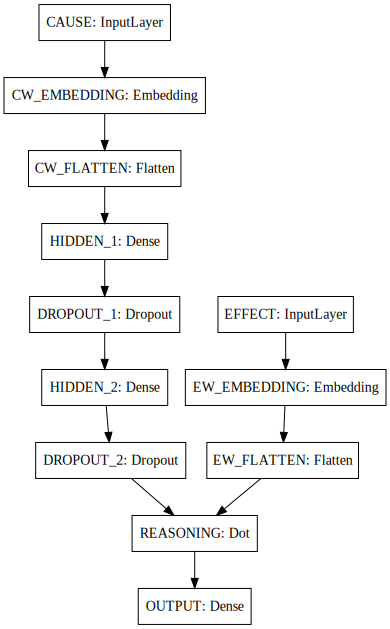

In [20]:
NCRM = ncrm()
NCRM.summary()
SVG(model_to_dot(NCRM).create(prog='dot', format='svg'))

# Train

In [115]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/selu+selu/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/tb_logs/selu+selu'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [116]:
NUM_LAYERS = 2
HIDDEN_SIZE = 300
HIDDEN_ACTIVATION = 'selu'
DROPOUT_RATE = 0.2
SEED = 42
OUTPUT_ACTIVATION = 'selu'
LOSS = 'mse'
OPTIMIZER = 'adam'

In [117]:
NCRM = ncrm(num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [118]:
BATCH_SIZE = 1024
NUM_EPOCHS = 64

In [119]:
history = NCRM.fit([xcTrain, xeTrain],
                   yTrain,
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   verbose=1,
                   callbacks=callbacks_list,
                   validation_data=([xcVal, xeVal], yVal),
                   shuffle=True)

Train on 1638134 samples, validate on 289083 samples
Epoch 1/64
1638134/1638134 [==============================] - 59s - loss: 0.9035 - val_loss: 0.8360
Epoch 2/64
1638134/1638134 [==============================] - 59s - loss: 0.7678 - val_loss: 0.8487
Epoch 3/64
1638134/1638134 [==============================] - 59s - loss: 0.7337 - val_loss: 1.0052
Epoch 4/64
1047552/1638134 [==================>...........] - ETA: 20s - loss: 0.7164

KeyboardInterrupt: 

In [120]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/relu+none/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/tb_logs/relu+none'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [51]:
BATCH_SIZE = 1024
NUM_EPOCHS = 12

In [52]:
history = NCRM.fit([xc, xe],
                   s,
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   verbose=1,
                   callbacks=callbacks_list,
                   shuffle=True)

Epoch 1/12
1927217/1927217 [==============================] - 74s - loss: 0.8948    
Epoch 2/12
1927217/1927217 [==============================] - 74s - loss: 0.8500    
Epoch 3/12
1927217/1927217 [==============================] - 74s - loss: 0.8417    
Epoch 4/12
1927217/1927217 [==============================] - 71s - loss: 0.8375    
Epoch 5/12
1927217/1927217 [==============================] - 78s - loss: 0.8348    
Epoch 6/12
1927217/1927217 [==============================] - 77s - loss: 0.8324    
Epoch 7/12
1927217/1927217 [==============================] - 73s - loss: 0.8311    
Epoch 8/12
1927217/1927217 [==============================] - 69s - loss: 0.8297    
Epoch 9/12
1927217/1927217 [==============================] - 78s - loss: 0.8289    
Epoch 10/12
1927217/1927217 [==============================] - 76s - loss: 0.8277    
Epoch 11/12
1927217/1927217 [==============================] - 69s - loss: 0.8270    
Epoch 12/12
1927217/1927217 [==============================] - 

# Predict

In [121]:
import pickle

In [122]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'rb') as fp:
    _, _, _, _, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel = pickle.load(fp)
    
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

In [123]:
NUM_LAYERS = 2
HIDDEN_SIZE = 300
HIDDEN_ACTIVATION = 'selu'
DROPOUT_RATE = 0.2
SEED = 42
OUTPUT_ACTIVATION = 'sigmoid'
LOSS = 'mse'
OPTIMIZER = 'adam'

In [124]:
NCRM = ncrm(num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [125]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/all_relu+none/weights.081-0.642673.hdf5'
NCRM.load_weights(filename)

In [97]:
def CPMI(pairs, length=None, sp_score=False):
    """
    Compute causal-PMI score
    """
    score = []
    if length == None:
        length = len(pairs)
    for p in pairs:
        c = np.array([word2index[p[0]]])
        e = np.array([word2index[p[1]]])
        CS = NCRM.predict([c, e])[0][0]
        score.append(CS)
    if not sp_score:
        try:
            return sum(score) / length
        except:
            return 0
    else:
        return score

def accuracy(a1, a2, actu, length_mode=2016, show=True):
    """
    Calculate Accuracy
    """
    if length_mode == 2016:
        l1 = [len(set([i[0] for i in a1[n]]+[i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]+[i[-1] for i in a2[n]])) for n in range(500)]
        A1 = [CPMI(a1[i], length=l1[i]) for i in range(500)]
        A2 = [CPMI(a2[i], length=l2[i]) for i in range(500)]
    elif length_mode == 2017:
        A1 = [CPMI(p) for p in a1]
        A2 = [CPMI(p) for p in a2]
    pred = []
    for i in range(500):
        if A1[i] >= A2[i]:
            pred.append(1)
        elif A1[i] < A2[i]:
            pred.append(2)
        else:
            pred.append(0)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    print('Accuracy: \t%.9f' % (ACC))
    if show:
        error = []
        l1 = [len(set([i[0] for i in a1[n]]))+len(set([i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]))+len(set([i[-1] for i in a2[n]])) for n in range(500)]
        for i in range(500):
            s1 = []
            s2 = []
            print('————————————————————————————————————')
            print(str(i+1)+':')
            for p in a1[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s1.append(CPMI([p], sp_score=True))
            print('------------------')
            for p in a2[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s2.append(CPMI([p], sp_score=True))
            if length_mode == 2016:
                try:
                    S1 = sum(sum(s1, []))/l1[i]
                except:
                    S1 = 0
                try:
                    S2 = sum(sum(s2, []))/l2[i]
                except:
                    S2 = 0
            elif length_mode == 2017:
                S1 = sum(sum(s1, []))/len(a1[i])
                S2 = sum(sum(s2, []))/len(a2[i])
            print('S1:------'+str(S1))
            print('S2:------'+str(S2))
            if S1 >= S2:
                pre = '1'
            elif S1 < S2:
                pre = '2'
            else:
                pre = '0'
            print('Predict Answer: '+pre)
            print('Correct Answer: '+str(actu[i]))
            if pre != str(actu[i]):
                error.append(i+1)
        return pred, error
    else:
        return pred

In [136]:
p, e = accuracy(devcp1, devcp2, devLabel, length_mode=2017)

Accuracy: 	0.548000000
————————————————————————————————————
1:
sun body 0.0322514
sun cast 0.995427
sun shadow 0.999994
rise body 0.00318285
rise cast 0.675804
rise shadow 0.953715
------------------
cut body 0.011271
cut cast 0.859796
cut shadow 0.968382
S1:------0.610062313383
S2:------0.613149593274
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
2:
know tolerate 0.912887
know difficult 0.801016
know behavior 0.671077
go tolerate 0.431401
go difficult 0.759938
go behavior 0.104623
hard tolerate 0.889637
hard difficult 0.806503
hard behavior 0.0562691
time tolerate 0.714381
time difficult 0.980531
time behavior 0.423068
------------------
feel tolerate 0.791992
feel difficult 0.534517
feel behavior 0.0685822
take tolerate 0.658479
take difficult 0.7527
take behavior 0.291021
advantage tolerate 0.14812
advantage difficult 0.0819427
advantage behavior 0.129678
kindness tolerate 0.963304
kindness difficult 0.0455372
kindness behavior 0.228972
S1:------0.62927753

attract woman 0.813791
attract give 0.510828
attract man 0.58729
attract phone 0.628562
attract number 0.970963
------------------
repulse woman 0.539029
repulse give 0.024024
repulse man 0.390975
repulse phone 0.0167516
repulse number 0.0141233
S1:------0.702286672592
S2:------0.196980595589
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
26:
open skydiver 0.1413
open glide 0.00968452
open safely 0.148102
open ground 0.914749
parachute skydiver 0.994912
parachute glide 0.998827
parachute safely 0.998075
parachute ground 0.867982
------------------
jump skydiver 0.951527
jump glide 0.689629
jump safely 0.128225
jump ground 0.775957
plane skydiver 0.990777
plane glide 0.910019
plane safely 0.979216
plane ground 0.767518
S1:------0.634203763912
S2:------0.774108547717
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
27:
toddler put 0.861554
toddler nap 0.993075
become put 0.890213
become nap 0.00159704
cranky put 0.601649
cranky nap 0.9999

lift fatigued 0.0206645
weight muscle 0.636941
weight become 0.413246
weight fatigued 0.125247
S1:------0.300055058363
S2:------0.2534884024
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
54:
cook melt 0.999954
stir melt 1.0
bowl melt 0.998496
------------------
cook blend 0.672802
cook together 0.00765958
stir blend 0.89121
stir together 0.0230993
bowl blend 0.0641558
bowl together 0.0239077
S1:------0.999483545621
S2:------0.280472338122
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
55:
man void 0.938982
sign void 0.946665
document void 0.998885
------------------
man become 0.930541
man official 0.981661
sign become 0.132064
sign official 0.993028
document become 0.0191868
document official 0.984757
S1:------0.961510896683
S2:------0.67353966739
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
56:
police recoil 0.376424
officer recoil 0.10445
drop recoil 0.955011
------------------
police go 0.878024
office

rob 911 0.457511
street call 0.639077
street 911 0.691982
------------------
see hail 0.762436
see cab 0.875359
woman hail 0.987391
woman cab 0.517841
get hail 0.417322
get cab 0.972633
rob hail 0.82085
rob cab 0.318386
street hail 0.892621
street cab 0.987319
S1:------0.740289604664
S2:------0.755215877295
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
87:
jog stomach 0.792184
jog hurt 0.974849
treadmill stomach 0.970657
treadmill hurt 0.975062
------------------
eat stomach 0.999894
eat hurt 0.911646
birthday stomach 0.00418127
birthday hurt 0.19985
cake stomach 0.884887
cake hurt 0.115643
S1:------0.928187832236
S2:------0.51935026135
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
88:
finish put 0.954394
finish plate 0.982665
finish sink 0.998054
eat put 0.96273
eat plate 0.954686
eat sink 0.929475
------------------
skip put 0.604311
skip plate 0.14628
skip sink 0.714831
dinner put 0.923227
dinner plate 0.969069
dinner sink 0.9645

witness acquit 0.999931
crime acquit 0.999368
testify acquit 0.999982
------------------
several convict 0.383054
witness convict 0.999998
crime convict 0.999998
testify convict 0.999999
S1:------0.774510892108
S2:------0.845762304962
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
128:
young parent 0.998235
young leave 0.966724
young babysitter 0.998834
start parent 0.849389
start leave 0.943308
start babysitter 0.820077
attend parent 0.998486
attend leave 0.907429
attend babysitter 0.993555
preschool parent 0.999789
preschool leave 0.184903
preschool babysitter 0.990504
------------------
make parent 0.984564
make leave 0.974991
make babysitter 0.99093
plan parent 0.973993
plan leave 0.918424
plan babysitter 0.788649
celebrate parent 0.83637
celebrate leave 0.117615
celebrate babysitter 0.72775
anniversary parent 0.480753
anniversary leave 0.227992
anniversary babysitter 0.269777
S1:------0.887602807333
S2:------0.690984113142
Predict Answer: 1
Correct Answer

intersection driver 0.99996
intersection pull 0.0230173
intersection side 0.76978
intersection road 0.99689
------------------
notice driver 0.151886
notice pull 0.00149298
notice side 0.0740359
notice road 0.008053
strand driver 0.228466
strand pull 0.0192366
strand side 0.87815
strand road 0.0904504
vehicle driver 1.0
vehicle pull 0.398838
vehicle side 0.84228
vehicle road 0.999037
S1:------0.775061771506
S2:------0.390993747026
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
150:
symptom hospital 0.999963
symptom send 0.289726
symptom home 0.00218978
clear hospital 0.192131
clear send 0.941661
clear home 0.0034018
------------------
family hospital 0.999479
family send 0.999077
family home 0.999055
visit hospital 0.84503
visit send 0.999978
visit home 0.538341
S1:------0.404845620622
S2:------0.896826803684
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
151:
get child 0.999806
get catch 0.975323
get life 0.99644
get threaten 0.27866

book dust 0.492076
book come 0.979216
S1:------0.542904831469
S2:------0.679811455309
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
171:
motorcyclist coast 0.0456302
motorcyclist halt 0.998987
twist coast 0.000483443
twist halt 0.859056
throttle coast 0.00721749
throttle halt 0.994186
------------------
motorcyclist shoot 0.699511
motorcyclist forward 0.952397
twist shoot 0.626143
twist forward 0.94863
throttle shoot 0.904537
throttle forward 0.996931
S1:------0.484259944462
S2:------0.854691425959
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
172:
teacher stick 0.00359465
teacher shoe 4.69784e-05
catch stick 0.45565
catch shoe 0.0983665
chew stick 0.99151
chew shoe 0.474502
------------------
teacher spit 0.0335444
catch spit 0.949892
chew spit 0.999924
S1:------0.337278218036
S2:------0.661120163898
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
173:
host gracious 0.912925
serve gracious 0.947273
dinner g

awakening abroad 0.535181
S1:------0.793639287197
S2:------0.558586339156
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
192:
bureau throw 0.0210292
bureau away 0.00547386
bureau unnecessary 0.438473
bureau content 0.010582
clutter throw 0.937304
clutter away 0.234991
clutter unnecessary 0.401612
clutter content 0.0194998
------------------
bureau lock 0.898039
bureau shut 0.963787
clutter lock 0.969901
clutter shut 0.526815
S1:------0.258620488865
S2:------0.83963522315
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
193:
receive student 0.999911
receive flaunt 0.0578648
receive test 0.940753
receive grade 0.990925
receive classmate 0.973307
perfect student 0.598295
perfect flaunt 0.893068
perfect test 0.095368
perfect grade 0.670403
perfect classmate 0.957038
score student 0.999954
score flaunt 0.0140519
score test 0.977302
score grade 0.999903
score classmate 0.99395
------------------
feign student 0.974525
feign flaunt 0.0292538
f

frame woman 0.554382
frame wrongly 0.957014
frame convict 0.415477
frame crime 0.96373
S1:------0.969455346465
S2:------0.722650803626
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
231:
girl slice 0.860478
girl apart 0.819263
apply slice 0.842568
apply apart 0.0655454
scissor slice 0.994724
scissor apart 0.938819
------------------
girl crinkle 0.879474
apply crinkle 0.280575
scissor crinkle 0.701872
S1:------0.753565942248
S2:------0.620640069246
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
232:
distrust woman 0.994745
distrust visit 0.324318
distrust family 0.86837
------------------
miss woman 0.965583
miss visit 0.986105
miss family 0.939407
S1:------0.729144285123
S2:------0.963698486487
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
233:
burst tooth 0.992953
burst begin 0.97037
burst chatter 0.934342
fit tooth 0.676003
fit begin 0.651093
fit chatter 0.0778068
laughter tooth 0.984947
laughter begin 0.

back take 0.991053
back notice 0.15187
back woman 0.998959
turn man 0.994557
turn take 0.870271
turn notice 0.067057
turn woman 0.997747
S1:------0.460089694903
S2:------0.758789272048
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
274:
woman stop 0.988257
woman see 0.831684
boyfriend stop 0.980112
boyfriend see 0.359029
get stop 0.998143
get see 0.996864
fight stop 0.997753
fight see 0.73507
------------------
woman plan 0.927008
woman vacation 0.0356976
woman together 0.080154
boyfriend plan 0.886233
boyfriend vacation 0.103601
boyfriend together 0.173691
get plan 0.990299
get vacation 0.904386
get together 0.933057
fight plan 0.993482
fight vacation 0.0113084
fight together 0.086315
S1:------0.860864002258
S2:------0.510435902126
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
275:
stick pick 0.946295
foot pick 0.73544
front pick 0.972465
------------------
stick trip 0.0139501
foot trip 0.0559948
front trip 0.511936
S1:------0.8847

cloud glance 0.871971
cloud watch 0.0151689
------------------
sun take 0.37992
sun sweater 0.109399
emerge take 0.0870044
emerge sweater 0.000217765
cloud take 0.0349189
cloud sweater 0.00383617
S1:------0.376955202005
S2:------0.10254936318
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
309:
yell football 0.993886
yell coach 0.842979
yell lose 0.586074
yell voice 0.991411
yell game 0.996131
fumble football 0.999989
fumble coach 0.995556
fumble lose 0.879417
fumble voice 0.0893709
fumble game 0.99999
ball football 0.999982
ball coach 0.994221
ball lose 0.91114
ball voice 0.0677321
ball game 0.999997
------------------
whistle football 0.955911
whistle coach 0.54209
whistle lose 0.0782811
whistle voice 0.910525
whistle game 0.993755
score football 0.99997
score coach 0.995258
score lose 0.468586
score voice 0.790707
score game 0.999989
touchdown football 0.999999
touchdown coach 0.995727
touchdown lose 0.554486
touchdown voice 0.0654832
touchdown game 0.999996

apprehend close 0.00451136
apprehend investigation 0.999999
suspect police 1.0
suspect close 0.0463162
suspect investigation 1.0
------------------
victim police 1.0
victim close 0.0648122
victim investigation 1.0
recover police 0.997886
recover close 0.0101608
recover investigation 0.999999
S1:------0.675137621583
S2:------0.678809691841
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
344:
rain go 0.258909
rain walk 0.989
subside go 0.01657
subside walk 0.598261
------------------
rain browse 0.012891
rain internet 0.000562461
subside browse 0.00252923
subside internet 0.00142407
S1:------0.465685076546
S2:------0.00435168262629
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
345:
cup blow 0.995534
tea blow 0.842521
scald blow 0.999819
hot blow 0.99992
------------------
cup pour 1.0
tea pour 1.0
scald pour 1.0
hot pour 1.0
S1:------0.959448337555
S2:------0.999999940395
Predict Answer: 2
Correct Answer: 1
—————————————————————————————

man saving 0.94194
man account 0.996446
want withdraw 0.826619
want saving 0.982621
want account 0.999566
save withdraw 0.975391
save saving 0.999972
save account 0.999985
------------------
man cut 0.864449
man back 0.994778
man make 0.912395
man frivolous 0.843748
man purchase 0.00198271
want cut 0.915385
want back 0.982422
want make 0.996848
want frivolous 0.420836
want purchase 0.985155
save cut 0.0603302
save back 0.677984
save make 0.531128
save frivolous 0.653529
save purchase 0.993617
S1:------0.968044797579
S2:------0.722305779764
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
384:
floor put 0.865285
floor shoe 0.977785
contain put 0.446092
contain shoe 0.000434608
broken put 0.949072
broken shoe 0.442911
glass put 0.912507
glass shoe 0.898116
------------------
paint put 0.969126
paint shoe 0.963333
wall put 0.927094
wall shoe 0.0880733
wet put 0.954003
wet shoe 0.999811
S1:------0.686525274097
S2:------0.816906771312
Predict Answer: 2
Correct Answer

try catch 0.705251
try ball 0.539174
intercept player 0.372015
intercept catch 0.468995
intercept ball 0.316389
S1:------0.957961112261
S2:------0.698953790797
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
416:
courtroom judge 0.999997
courtroom pound 0.00132732
courtroom gavel 0.97912
break judge 0.781003
break pound 0.981736
break gavel 0.569243
uproar judge 0.983112
uproar pound 0.124338
uproar gavel 0.60863
------------------
jury judge 1.0
jury pound 0.000292222
jury gavel 0.892636
announce judge 0.857967
announce pound 0.0707944
announce gavel 0.743382
verdict judge 0.999999
verdict pound 0.00418967
verdict gavel 0.729219
S1:------0.669834016266
S2:------0.588719851541
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
417:
hit woman 0.978699
hit banish 0.362643
hit property 0.566782
ball woman 0.805253
ball banish 0.808599
ball property 0.0184366
yard woman 0.782763
yard banish 0.717332
yard property 0.942801
------------------
tr

student assignment 0.999936
student home 0.311757
rush leave 0.356663
rush assignment 0.0209261
rush home 0.0314475
get leave 0.993244
get assignment 0.977276
get home 0.866622
time leave 0.996867
time assignment 0.998871
time home 0.11144
------------------
student bring 0.667462
student lunch 0.992826
rush bring 0.614716
rush lunch 0.481233
get bring 0.975876
get lunch 0.999125
time bring 0.939155
time lunch 0.988133
S1:------0.622042670536
S2:------0.832315564156
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
445:
difficult write 0.976729
difficult biography 0.999828
difficult life 0.963964
interview write 0.999713
interview biography 1.0
interview life 0.926791
------------------
intrigue write 0.996586
intrigue biography 0.999973
intrigue life 0.954914
work write 0.999944
work biography 0.999884
work life 0.99961
S1:------0.977837602297
S2:------0.99181869626
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
446:
man donate 0.962875

land become 0.785365
land strong 0.280518
S1:------0.700890503824
S2:------0.45162018761
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
473:
teacher pass 0.472825
teacher note 0.950369
assign pass 0.127369
assign note 0.984256
homework pass 0.127496
homework note 0.916638
------------------
teacher groan 0.00156462
assign groan 6.72231e-05
homework groan 0.00612207
S1:------0.596492278079
S2:------0.00258463630598
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
474:
season people 0.0463033
season evacuate 0.00936097
season home 0.0660009
change people 0.249205
change evacuate 0.0348841
change home 0.0741793
summer people 0.030422
summer evacuate 0.0250152
summer home 0.149481
autumn people 0.000492131
autumn evacuate 0.00288375
autumn home 0.0103854
------------------
season leaf 0.969034
season fall 0.999585
season tree 0.839088
change leaf 0.0737842
change fall 0.894163
change tree 0.210036
summer leaf 0.994826
summer fall 0.998993
s

In [135]:
p, e = accuracy(testcp1, testcp2, testLabel, length_mode=2017)

Accuracy: 	0.542000000
————————————————————————————————————
1:
fragile item 0.0184938
fragile package 0.00189741
fragile bubble 0.996757
fragile wrap 0.3035
------------------
small item 0.965864
small package 0.279714
small bubble 0.997957
small wrap 0.264736
S1:------0.330161977501
S2:------0.627067878842
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
2:
empty retrieve 0.997265
empty ticket 0.966209
empty stub 0.997954
pocket retrieve 0.899015
pocket ticket 0.992566
pocket stub 0.996908
------------------
empty find 0.0706932
empty weapon 0.30682
pocket find 0.02182
pocket weapon 0.863489
S1:------0.974986245235
S2:------0.315705486108
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
3:
invade disappear 0.63699
------------------
invade eat 0.017665
invade wood 0.171215
S1:------0.636989533901
S2:------0.0944400029257
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
4:
traveler check 0.938066
traveler passport 

————————————————————————————————————
23:
man pack 0.206911
man warm 0.00455032
man clothing 0.00973724
anticipate pack 0.0576808
anticipate warm 0.000237909
anticipate clothing 4.23134e-05
cold pack 0.994945
cold warm 0.999999
cold clothing 0.0306948
weather pack 0.546652
weather warm 0.971754
weather clothing 0.000551309
trip pack 0.957588
trip warm 0.0195782
trip clothing 0.000199301
------------------
man travel 0.218174
man big 0.990313
anticipate travel 0.786316
anticipate big 0.184719
cold travel 0.820467
cold big 0.84685
weather travel 0.998453
weather big 0.681677
trip travel 0.99999
trip big 0.85177
S1:------0.3200747262
S2:------0.737872970104
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
24:
student raise 0.98701
student hand 0.00996622
know raise 0.989219
know hand 0.96683
answer raise 0.912968
answer hand 0.0353933
question raise 0.981127
question hand 0.158991
------------------
student goof 0.00324073
know goof 0.895061
answer goof 0.0507804
qu

eat sticky 0.996462
doughnut hand 0.378976
doughnut become 0.54424
doughnut sticky 0.997792
------------------
sweet hand 0.83779
sweet become 0.134659
sweet sticky 0.999537
tooth hand 0.728503
tooth become 0.433164
tooth sticky 0.996514
S1:------0.678525025646
S2:------0.688361150523
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
44:
push open 0.788634
------------------
push lock 0.999538
S1:------0.788633942604
S2:------0.999537587166
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
45:
test activist 0.976633
test boycott 0.374301
quality activist 0.699147
quality boycott 0.851576
assurance activist 0.999419
assurance boycott 0.740899
------------------
manufacture activist 0.71712
manufacture boycott 0.776014
child activist 0.999438
child boycott 0.980101
labor activist 0.999687
labor boycott 0.999473
S1:------0.773662591974
S2:------0.911971906821
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
46:
drill mo

see porch 0.481487
lightning woman 0.381269
lightning sit 0.120783
lightning outside 0.796891
lightning porch 0.995145
S1:------0.656696865335
S2:------0.600293448816
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
68:
could man 0.997315
could wear 0.302062
could lifejacket 0.921902
swim man 0.667803
swim wear 0.519543
swim lifejacket 0.999945
------------------
shallow man 0.11659
shallow wear 0.000328419
shallow lifejacket 0.977262
S1:------0.734761496385
S2:------0.364727012018
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
69:
woman delete 0.672436
woman document 0.860155
make delete 0.996548
make document 0.988598
typo delete 0.99994
typo document 0.890173
word delete 0.99996
word document 0.999692
processor delete 0.999954
processor document 0.998811
------------------
woman hit 0.716389
woman backspace 0.999815
woman key 0.462557
make hit 0.92024
make backspace 0.999858
make key 0.998309
typo hit 0.459008
typo backspace 0.999992

fall forecast 0.999956
fall predict 0.999738
fall heavy 0.794716
fall wind 0.98832
power forecast 0.999653
power predict 0.997382
power heavy 0.945757
power wind 0.999826
line forecast 0.988352
line predict 0.991132
line heavy 0.932218
line wind 0.713741
S1:------0.495383735901
S2:------0.899823322892
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
102:
speaker bore 0.897683
make bore 0.525323
politically bore 0.98489
incorrect bore 0.973862
comment bore 0.754684
------------------
speaker offend 0.00475675
make offend 0.0489959
politically offend 0.00437414
incorrect offend 0.000390025
comment offend 0.066627
S1:------0.827288341522
S2:------0.0250287678035
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
103:
prick bead 0.999028
prick sweat 0.998841
prick drip 1.0
prick face 0.997045
pin bead 0.990655
pin sweat 0.0247986
pin drip 0.999127
pin face 0.698391
------------------
prick drop 0.958842
prick blood 0.999616
prick form 0.0409367

tooth proud 0.00428933
S1:------0.234647628199
S2:------0.494200862013
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
136:
pay boy 0.99907
pay fail 0.157519
pay history 0.985987
pay exam 0.990739
attention boy 0.998476
attention fail 0.0281318
attention history 0.992683
attention exam 0.4955
class boy 0.999145
class fail 0.347538
class history 0.983392
class exam 0.99989
------------------
forget boy 0.999126
forget fail 0.413728
forget history 0.989735
forget exam 0.595848
study boy 0.960747
study fail 0.0412046
study history 0.999766
study exam 0.99928
S1:------0.748172566916
S2:------0.749929246493
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
137:
earthquake downtown 0.785747
earthquake building 0.97814
earthquake collapse 1.0
hit downtown 0.593979
hit building 0.343613
hit collapse 0.999997
------------------
crime downtown 0.935521
crime building 0.0906263
crime collapse 0.999953
rate downtown 0.031524
rate building 0.0670802
r

————————————————————————————————————
172:
welcome play 0.978091
welcome mean 0.22302
welcome trick 0.314882
------------------
dislike play 0.912467
dislike mean 0.475783
dislike trick 0.0924469
S1:------0.505330796043
S2:------0.493565720816
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
173:
eat crave 0.999747
eat glass 0.979057
eat milk 1.0
cookie crave 0.999552
cookie glass 0.995369
cookie milk 0.999999
------------------
bake crave 0.99829
bake glass 0.999939
bake milk 1.0
bread crave 0.999909
bread glass 0.999918
bread milk 1.0
S1:------0.995620588462
S2:------0.999675879876
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
174:
begin turn 0.760567
begin headlight 0.0258646
rain turn 0.942532
rain headlight 0.988258
------------------
begin shift 0.989816
begin car 0.000466913
begin reverse 0.902206
rain shift 0.688612
rain car 0.173391
rain reverse 0.992554
S1:------0.679305565543
S2:------0.624507601111
Predict Answer: 1
Correct 

ZeroDivisionError: division by zero